In [1]:
import torch 
from torch import nn

from src.utils.cifar_data import data_split
from src.utils.train import train
from src.models.vgg import VGG
from src.utils.io import load_pickle
from src.utils.evaluate import evaluate_model, tensors2numpy_array, plot_confusion_matrix

from sklearn.metrics import accuracy_score

In [2]:
USE_GPU = True

TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 512
TEST_BATCH_SIZE = 1024

RANDOM_STATE = 42

DEVICE = "cuda" if USE_GPU and torch.cuda.is_available() else "cpu"

VGG_TYPE = 'VGG11'

EPOCH_NUM = 15

In [3]:
datasets, loaders = data_split(
    TRAIN_BATCH_SIZE,
    VAL_BATCH_SIZE,
    TEST_BATCH_SIZE,
    val_size=0.2,
    download=False,
    random_state=RANDOM_STATE
)

In [4]:
state_dict = torch.load('../saved_models/vgg_16_state_dict.ckpt', map_location=torch.device('cpu'))
model = VGG('VGG16').to(DEVICE)
model.load_state_dict(state_dict['model'])

<All keys matched successfully>

 Accuracy on test = 0.8553


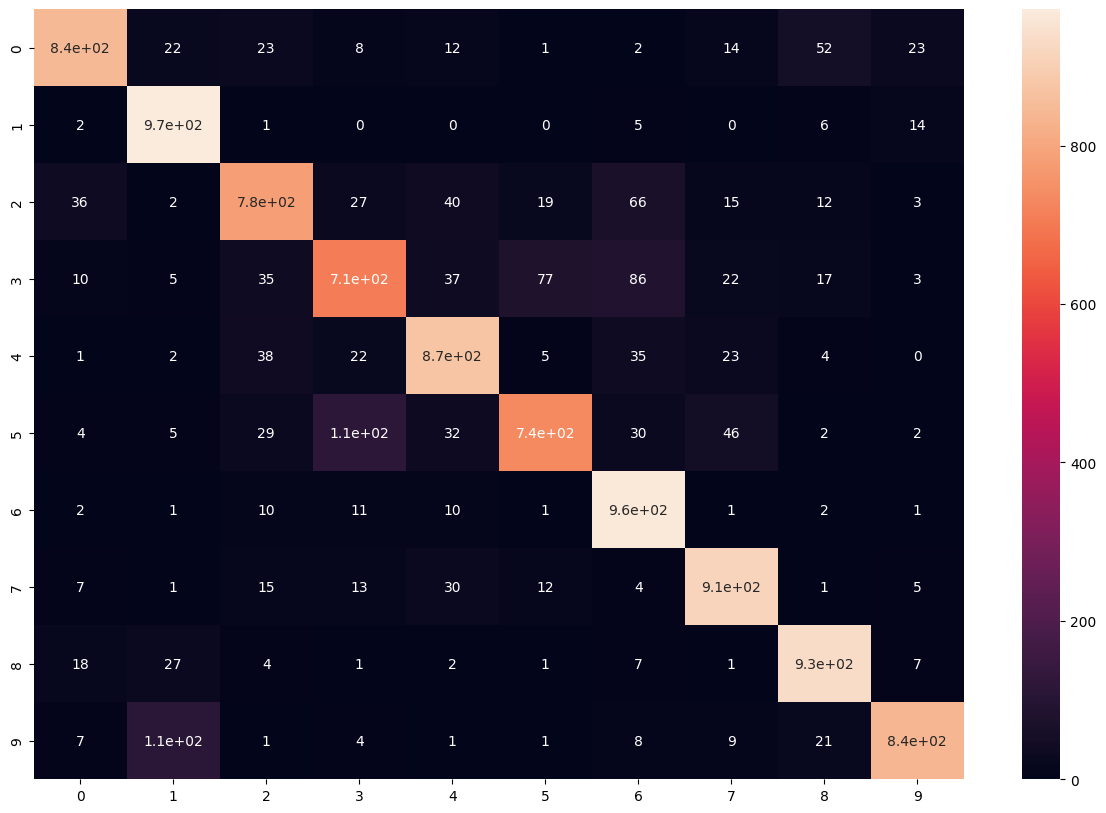

In [5]:
predictions = list()

model.eval()
with torch.no_grad():
    for data in loaders['test']:
        inputs, targets = data['image'], data['target']
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)

        _, pred = torch.max(outputs, dim=1)
        predictions.append(pred)

y_true = loaders['test'].dataset.targets
y_pred = tensors2numpy_array(predictions)

print(f' Accuracy on test = {accuracy_score(y_true, y_pred)}')

plot_confusion_matrix(y_true, y_pred)

In [12]:
def get_representations(model, loader, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for data in loader:
            inputs, targets = data['image'], data['target']
            inputs, targets = inputs.to(device), targets.to(device)

            y_pred = model(inputs)

            outputs.append(y_pred)
            labels.append(targets)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [13]:
outputs, labels = get_representations(model, loaders['test'], 'cpu')

In [24]:
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# We can then perform PCA on these representations to plot them in two dimensions.

def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def plot_representations(data, labels, title, n_images = None):
            
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
                
    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    ax.set_title(title)
    ax.grid()
    plt.show()

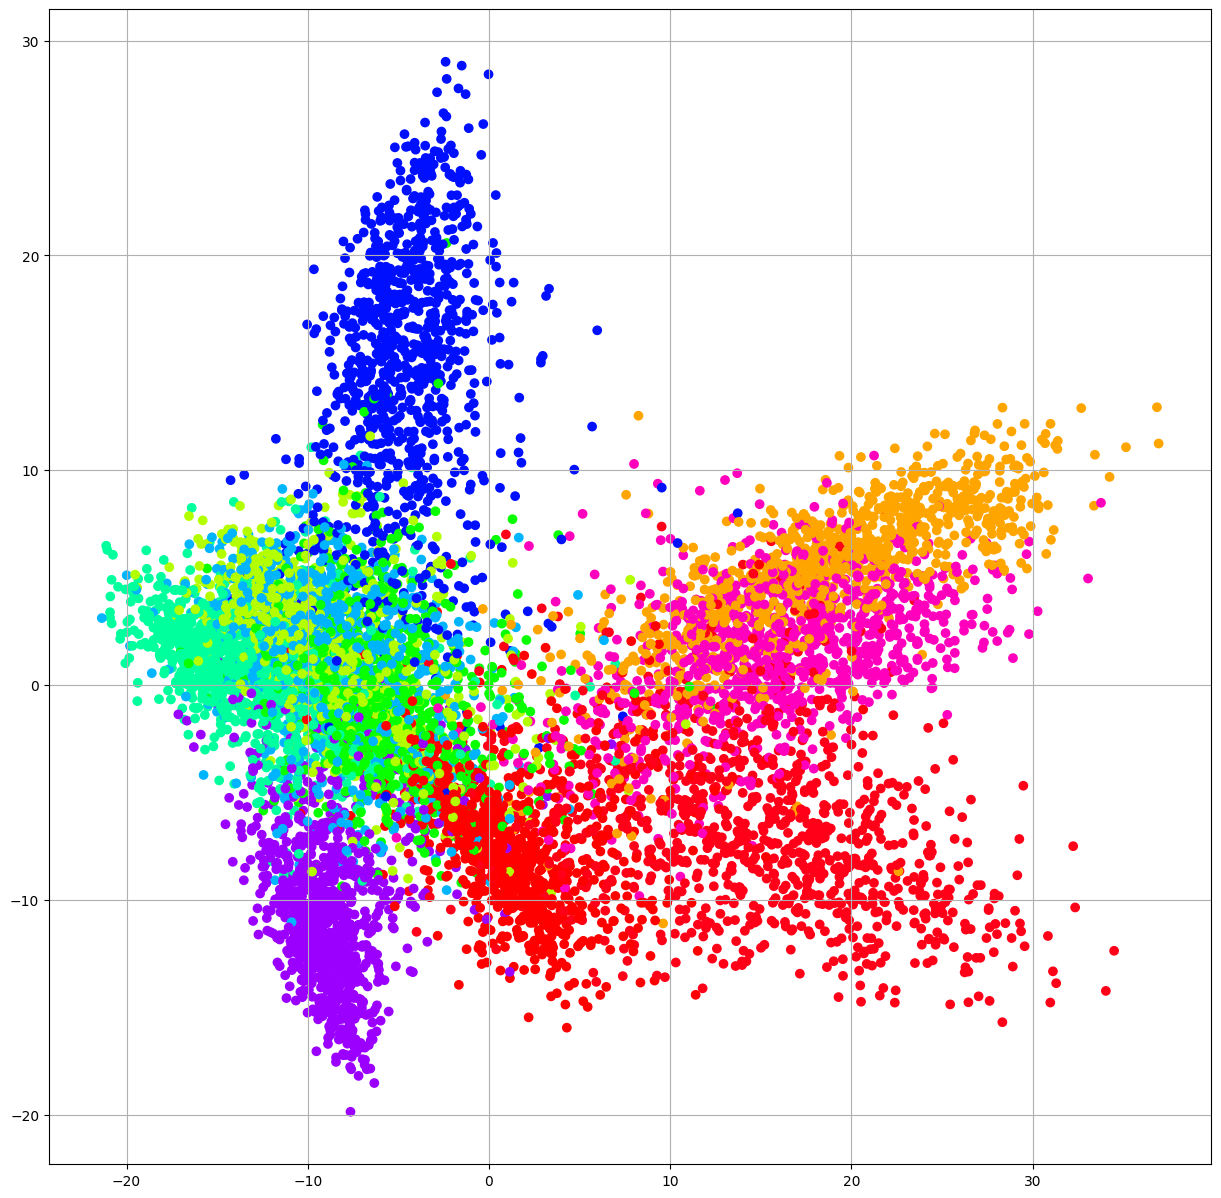

In [23]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

In [25]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

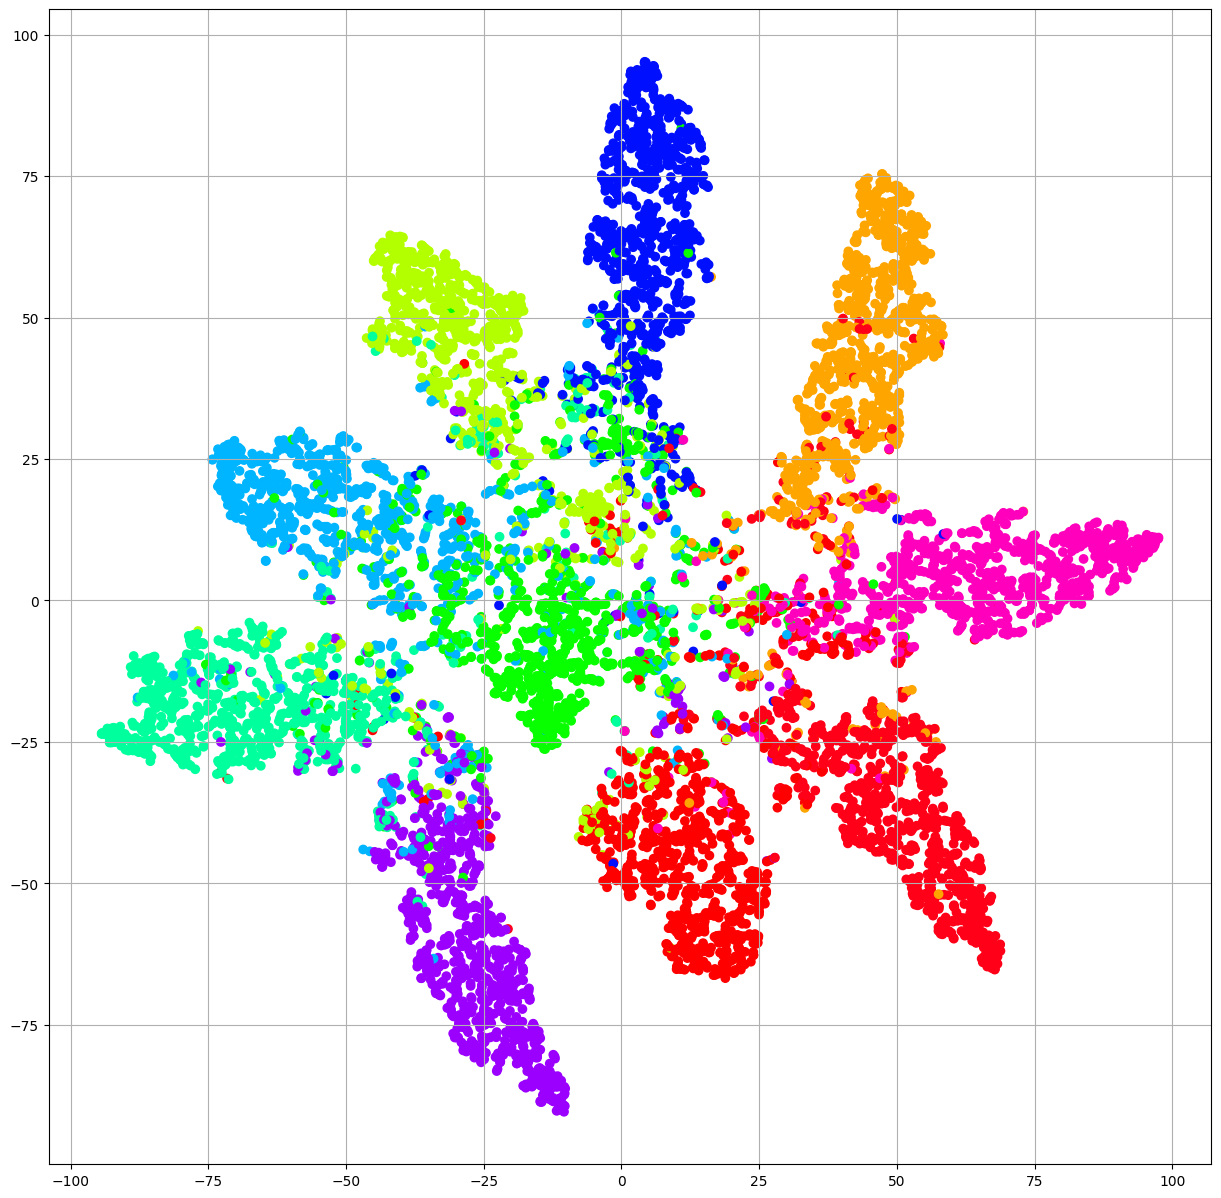

In [26]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels)